# Vehicle-based observation data processing and simple simulation experiments

## Context
### Purpose
This notebook demonstrates our general workflow for processing vehicle-based methane observation data and performing preliminary source identification.

### Description
This notebook uses two data files: data1.csv comes from measurements taken during vehicle movement, while data2.csv comes from measurements taken at a fixed vehicle location. This is to fully demonstrate the processing methods used in different cases. These data are all from our actual field observations, but please note that we have modified the latitude and longitude information to comply with legal requirements, which may cause some offset in the drawings.

### Highlights
* Visualisation to explore vehicle-based observation data.
* Analyse the synchronisation of measurement signals.
* Use simulation experiments to understand the source of measurement signals.
* Use simulation experiments to break down measurement signals and obtain regional baseline values.

## Load libraries

In [1]:
#system
import os
import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import display

#visualisation
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

#data analysis
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import coherence, welch

from function.help import geo_to_local, moving_average
from function.gaussian_plume import gaussian_plume, inverse_gaussian_plume

## Load data

Load data files. data1.csv is from a mobile observation process that captured methane emissions from a motorway service area. data2.csv is from a fixed observation process that measured methane and ethane emissions from a natural gas station downwind.

In [2]:
df1 = pd.read_csv('data1.csv', sep =',')
df1

,lat,lon,CH4
0,27.06224,112.4609,2273.967
1,27.06261,112.4607,2273.967
2,27.06270,112.4606,2297.144
3,27.06295,112.4605,2297.144
4,27.06328,112.4604,2297.144
...,...,...,...
111,27.09791,112.4545,2279.216
112,27.09836,112.4546,2279.216
113,27.09845,112.4546,2277.614
114,27.09897,112.4546,2277.614


In [3]:
df2 = pd.read_csv('data2.csv', sep =',')
df2

,CH4,C2H6
0,2.480,24.625
1,2.468,23.868
2,2.484,24.744
3,2.416,22.330
4,2.319,18.550
...,...,...
1219,2.088,9.578
1220,2.090,9.886
1221,2.086,9.759
1222,2.088,9.722


In addition, we will set some parameters to define the Gaussian plume model and perform unit conversions.

|        |                                 |        |             |
|:------:|:-------------------------------:|:------:|:-----------:|
|     u  |           wind speed            | M_PER_DEG | Distance per degree |
| Ry / ry / Rz / rz | Gaussian plume model parameters |     T  |     Temperature |
|         P |      Atmospheric pressure       |     M  |     Molar mass |
|         R |     universal gas constant      |        |             |

Note: These parameters should be set separately for each simulation experiment based on meteorological measurements, but since this data is regulated information, we used uniform values, which may affect the results of subsequent experiments.

$$
c(x, y, z) = \frac{q}{2 \pi \bar{u} R_{y} x^{r_y} R_{z} x^{r_z}} \exp \left(-\frac{y^2}{2\left(R_{y} x^{r_y}\right)^2}\right)\left[\exp \left(-\frac{(z-h)^2}{2\left(R_{z} x^{r_z}\right)^2}\right) +\exp \left(-\frac{(z+h)^2}{2\left(R_{z} x^{r_z}\right)^2}\right)\right]
$$

In [4]:
u = 3         # wind speed (m/s)
Ry, ry = 0.469, 0.903 #Horizontal diffusion parameter
Rz, rz = 0.017, 1.380 #Vertical diffusion parameter

M_PER_DEG = 111320 # m

T = 298.15       # (K)
P = 101325       # (Pa)
M = 0.016        # (kg/mol) — CH₄
M_C2H6 = 0.03007 # (kg/mol) — C2H6
R = 8.314        # (J/mol·K)

## Mobile observation
Mobile measurement is the most common form of vehicle-based measurement, whereby a vehicle equipped with instruments moves along a road and attempts to capture signals generated by nearby emission sources, which typically manifest as small peaks on a smooth baseline.

### Visualisation

Plot methane measurement signals in sequence.

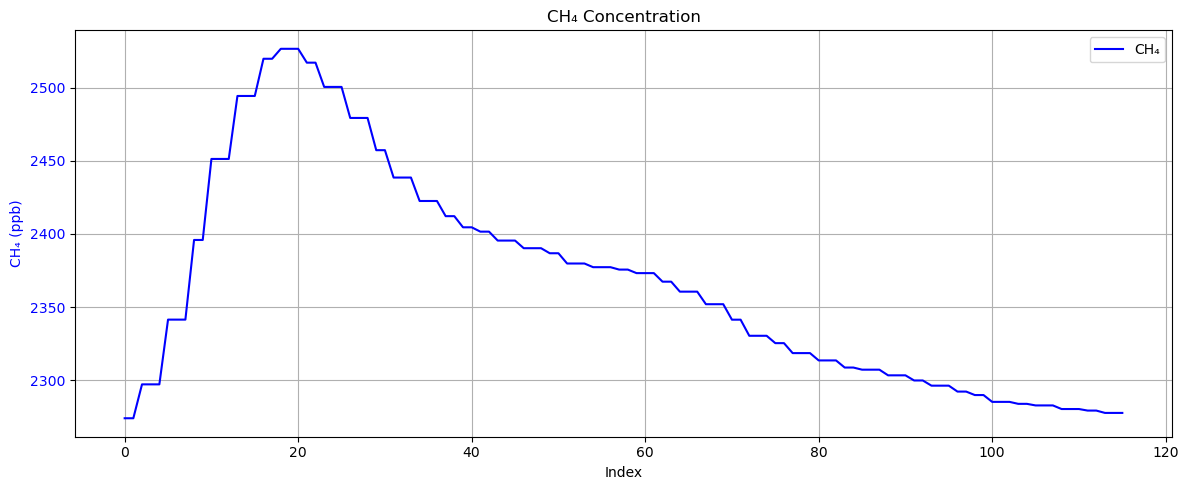

In [5]:
df1 = df1.dropna(subset=['CH4'])  # Filter out entire rows where CH4 is NaN.

lat = df1['lat'].values
lon = df1['lon'].values
CH4 = df1['CH4'].values

fig, ax = plt.subplots(figsize=(12, 5))

color = 'blue'
ax.set_xlabel('Index')
ax.set_ylabel('CH₄ (ppb)', color=color)
ax.plot(CH4, color=color, label='CH₄')
ax.tick_params(axis='y', labelcolor=color)
ax.grid(True)

ax.legend(loc='upper right')
plt.title('CH₄ Concentration')
plt.tight_layout()
plt.show()

This is a typical case where the peak on the baseline can be clearly seen. Next, we can plot the measurement signal on a map to explore where this signal might come from.

In [6]:
ref_lat = np.mean(lat)
ref_lon = np.mean(lon)

min_lat = np.min(lat)
max_lat = np.max(lat)
min_lon = np.min(lon)
max_lon = np.max(lon)

vmin = np.nanmin(CH4)
vmax = np.nanmax(CH4)
q1 = vmin + (vmax - vmin) * 0.25
q2 = vmin + (vmax - vmin) * 0.50
q3 = vmin + (vmax - vmin) * 0.75

heat_data = [[lat_, lon_, ch4_val] for lat_, lon_, ch4_val in zip(lat, lon, CH4) if not np.isnan(ch4_val)]

m = folium.Map(location=[ref_lat, ref_lon], zoom_start=13, tiles='cartodbpositron')

HeatMap(
    heat_data,
    radius=15,
    blur=25,
    min_opacity=0.3,
    gradient={
        0.00: 'blue',
        0.25: 'cyan',
        0.50: 'lime',
        0.75: 'yellow',
        1.00: 'red'
    },
).add_to(m)

# legend
legend_html = f'''
<div style="
    position: fixed;
    bottom: 50px; left: 50px; width: 200px; height: 150px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;
">
    <i style="background:blue;opacity:0.6;width:20px;height:20px;display:inline-block;"></i> < {q1:.1f} ppb<br>
    <i style="background:cyan;opacity:0.6;width:20px;height:20px;display:inline-block;"></i> {q1:.1f}–{q2:.1f} ppb<br>
    <i style="background:lime;opacity:0.6;width:20px;height:20px;display:inline-block;"></i> {q2:.1f}–{q3:.1f} ppb<br>
    <i style="background:yellow;opacity:0.6;width:20px;height:20px;display:inline-block;"></i> {q3:.1f}–{vmax:.1f} ppb<br>
    <i style="background:red;opacity:0.6;width:20px;height:20px;display:inline-block;"></i> > {vmax:.1f} ppb
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

display(m)

By combining satellite images and location information, we can tentatively determine that this signal originated from a service area along the motorway.

### Simulation experiment

A very obvious problem with mobile observations is that plumes at these locations often receive stronger interference. One strategy is to process the measurement sequence using low quantile values within the grid.

In this example, we will use the 5th percentile value in a 500m grid.

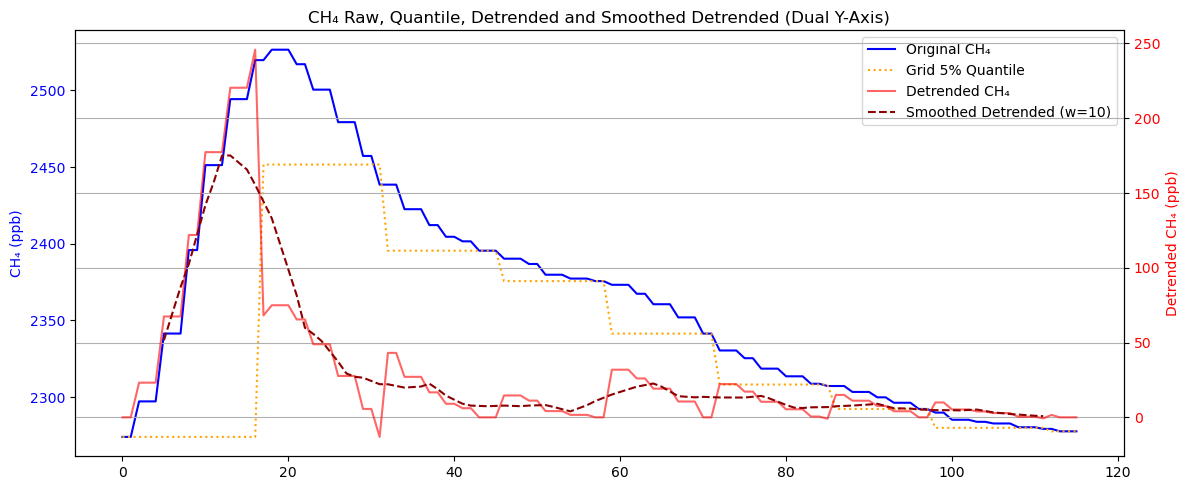

In [7]:
GRID_SIZE_M = 500         # Grid size (m)
QUANTILE = 0.05           # Quantile

# Reference point (domain centre point)
ref_lat = np.mean(lat)
ref_lon = np.mean(lon)

x, y = geo_to_local(lat, lon, ref_lat, ref_lon, M_PER_DEG)

ix = np.floor(x / GRID_SIZE_M).astype(int)
iy = np.floor(y / GRID_SIZE_M).astype(int)
grid_ids = list(zip(ix, iy))

grid_q10 = {}
grid_centers = {}
for gid in set(grid_ids):
    indices = [i for i, g in enumerate(grid_ids) if g == gid]
    if indices:
        grid_q10[gid] = np.quantile(CH4[indices], QUANTILE)
        grid_centers[gid] = (
            (gid[0] + 0.5) * GRID_SIZE_M,
            (gid[1] + 0.5) * GRID_SIZE_M
        )

grid_q_vals = np.array([grid_q10.get(gid, np.nan) for gid in grid_ids])
CH4_detrended = CH4 - grid_q_vals

# Smooth Detrended CH₄
CH4_detrended_smooth = moving_average(CH4_detrended, 10)
smooth_indices = np.arange(len(CH4_detrended_smooth)) + 5  # 对齐中心位置

plt.figure(figsize=(12, 5))
ax1 = plt.gca()

line1 = ax1.plot(CH4, label='Original CH₄', color='blue')
line3 = ax1.plot(grid_q_vals, label='Grid 5% Quantile', color='orange', linestyle=':')
ax1.set_ylabel('CH₄ (ppb)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
line2 = ax2.plot(CH4_detrended, label='Detrended CH₄', color='red', alpha=0.6)
line4 = ax2.plot(smooth_indices, CH4_detrended_smooth, label='Smoothed Detrended (w=10)', color='darkred', linestyle='--')
ax2.set_ylabel('Detrended CH₄ (ppb)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

lines = line1 + line3 + line2 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.xlabel('Sample Index')
plt.title('CH₄ Raw, Quantile, Detrended and Smoothed Detrended (Dual Y-Axis)')
plt.grid(True)
plt.tight_layout()
plt.show()

As can be seen, the processed sequence retains the peaks and remains aligned with the original sequence, while the smoothed sequence is more consistent with our physical intuition.

We can also project the quantile values onto a map to see if any areas have values that are significantly higher than others.

In [8]:
m = folium.Map(location=[ref_lat, ref_lon], zoom_start=13, tiles='cartodbpositron')

for gid, (cx, cy) in grid_centers.items():
    qval = grid_q10[gid]

    x0 = (gid[0]) * GRID_SIZE_M
    y0 = (gid[1]) * GRID_SIZE_M
    x1 = x0 + GRID_SIZE_M
    y1 = y0 + GRID_SIZE_M

    lat0, lon0 = ref_lat + y0 / M_PER_DEG, ref_lon + x0 / (M_PER_DEG * np.cos(np.radians(ref_lat)))
    lat1, lon1 = ref_lat + y1 / M_PER_DEG, ref_lon + x1 / (M_PER_DEG * np.cos(np.radians(ref_lat)))
    latc, lonc = ref_lat + cy / M_PER_DEG, ref_lon + cx / (M_PER_DEG * np.cos(np.radians(ref_lat)))

    folium.Rectangle(
        bounds=[(lat0, lon0), (lat1, lon1)],
        color='black',
        weight=1,
        fill=False
    ).add_to(m)

    folium.Marker(
        location=[latc, lonc],
        popup=f'{qval:.1f} ppb',
        icon=folium.DivIcon(html=f'<div style="font-size: 10px; color: darkgreen;">{qval:.1f}</div>')
    ).add_to(m)

display(m)

Next, we can run simulation experiments using the new concentration sequence as a benchmark to verify whether the source originates from a specific location or direction.

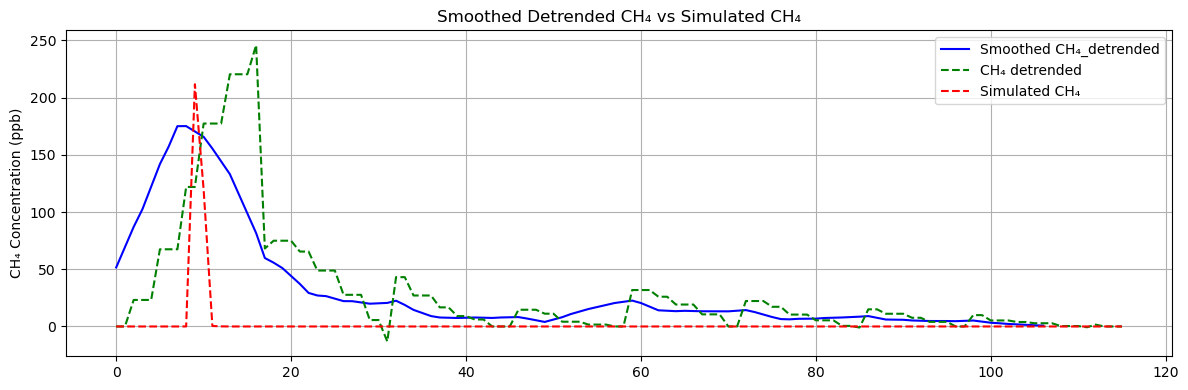

In [9]:
# wind direction
wind_deg = 90.00  # North is 0 degrees, rotate clockwise

# If you want to expand to multiple sources, you can add them directly here.
sources = [
    (27.064591, 112.460118, 200),
]

min_lat, max_lat = lat.min(), lat.max()
min_lon, max_lon = lon.min(), lon.max()

ref_lat = np.mean(lat)
ref_lon = np.mean(lon)

# Convert the origin to local xy coordinates
sources_lat = [s[0] for s in sources]
sources_lon = [s[1] for s in sources]
sources_q = np.array([s[2] for s in sources])
sources_x, sources_y = geo_to_local(sources_lat, sources_lon, ref_lat, ref_lon, M_PER_DEG)

sample_x, sample_y = geo_to_local(lat, lon, ref_lat, ref_lon, M_PER_DEG)

sim_CH4 = gaussian_plume(
    sample_x, sample_y,
    sources_x, sources_y, sources_q,
    u, Ry, ry, Rz, rz, wind_deg,
    T, P, M, R
)

fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.plot(CH4_detrended_smooth, label='Smoothed CH₄_detrended', color='blue')
ax1.plot(CH4_detrended, label='CH₄ detrended', color='green', linestyle='--')
ax1.plot(sim_CH4, label='Simulated CH₄', color='red', linestyle='--')
ax1.set_ylabel('CH₄ Concentration (ppb)')
ax1.set_title('Smoothed Detrended CH₄ vs Simulated CH₄')
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.show()

It can be seen that similar plumes can indeed be generated from this service area.

In [10]:
MAE = mean_absolute_error(CH4_detrended, sim_CH4)
RMSE = np.sqrt(mean_squared_error(CH4_detrended, sim_CH4))
print(f"MAE: {MAE:.2f}, RMSE: {RMSE:.2f}")

MAE: 28.69, RMSE: 56.28


The values of MAE and RMSE are relatively high because the simulation cannot be strictly aligned spatially.

## Fixed observation

Some locations are clearly strong sources of methane emissions, such as natural gas stations or livestock farms. In addition, they often emit other gases in conjunction with methane, such as ethane or nitrous oxide. When concerned about the emission intensity of these locations, we conduct active measurements downwind.

The sample data in this section comes from measurements taken at natural gas stations.

### Visualisation

Since natural gas stations emit both methane and ethane, plot both of these observation data.

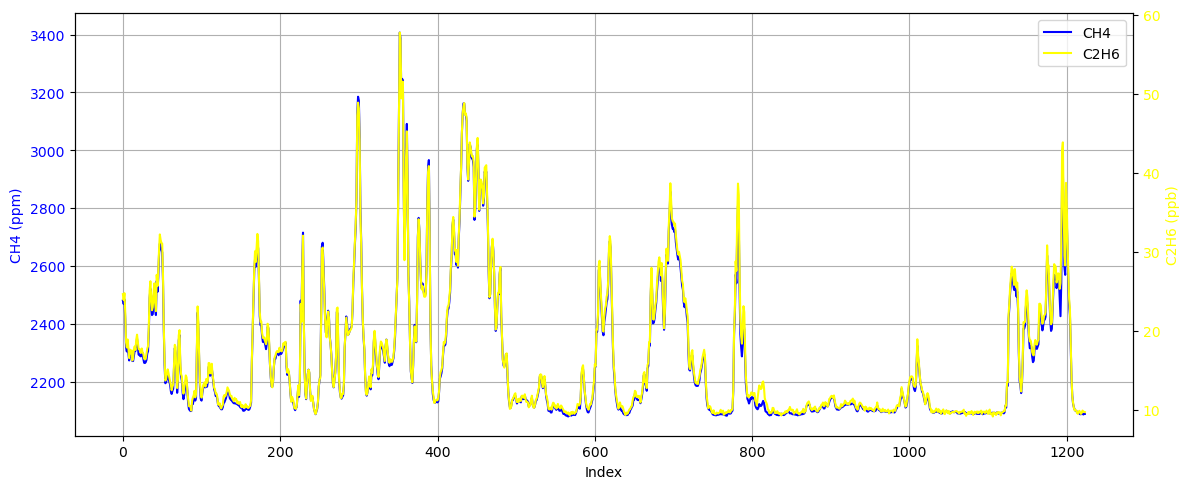

In [11]:
df2 = df2.dropna(subset=['CH4'])  # Filter out entire rows where CH4 is NaN.

CH4 = df2['CH4'].values
C2H6 = df2['C2H6'].values

CH4 = CH4*1000 # ppm to ppb

fig, ax1 = plt.subplots(figsize=(12, 5))

color1 = 'blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('CH4 (ppm)', color=color1)
ax1.plot(CH4, color=color1, label='CH4')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

ax2 = ax1.twinx()  # Shared x-axis
color2 = 'yellow'
ax2.set_ylabel('C2H6 (ppb)', color=color2)
ax2.plot(C2H6, color=color2, label='C2H6')
ax2.tick_params(axis='y', labelcolor=color2)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('')
plt.tight_layout()
plt.show()

It can be seen that although the values are different, these two signals change almost synchronously. Furthermore, we can use coherence analysis and PSD to analyse these two signals.

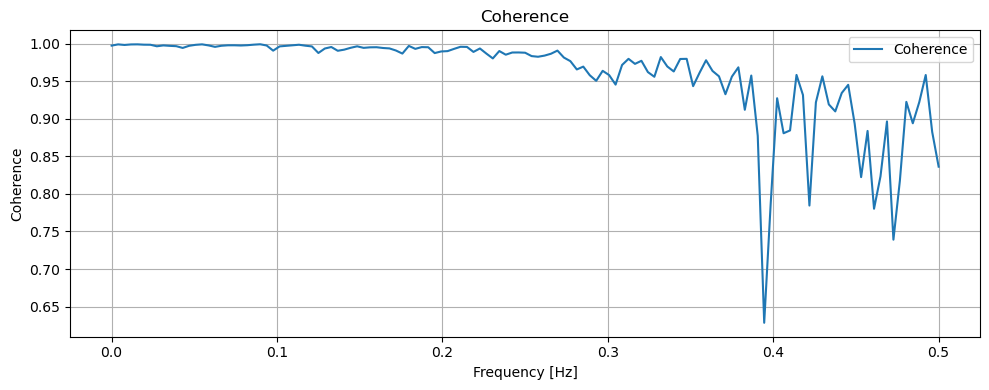

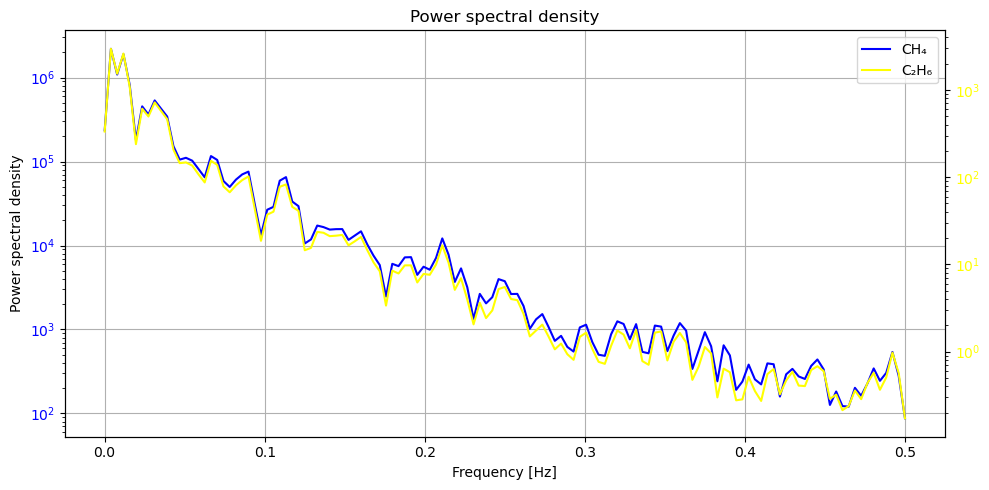

In [12]:
Fs = 1  # Sampling frequency

# Coherence
f_coh, Cxy = coherence(CH4, C2H6, fs=Fs)

# PSD
f1, Pxx1 = welch(CH4, fs=Fs, nperseg=min(256, len(CH4)))
f2, Pxx2 = welch(C2H6, fs=Fs, nperseg=min(256, len(C2H6)))

fig1, ax_coh = plt.subplots(figsize=(10, 4))
ax_coh.plot(f_coh, Cxy, label='Coherence', color='tab:blue')
ax_coh.set_ylabel('Coherence')
ax_coh.set_title('Coherence')
ax_coh.legend()
ax_coh.grid(True)
ax_coh.set_xlabel('Frequency [Hz]')
plt.tight_layout()
plt.show()

fig2, ax1 = plt.subplots(figsize=(10, 5))

ax1.semilogy(f1, Pxx1, 'blue', label='CH₄')
ax1.set_ylabel('Power spectral density')
ax1.set_xlabel('Frequency [Hz]')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.semilogy(f2, Pxx2, 'yellow', label='C₂H₆')
ax2.tick_params(axis='y', labelcolor='yellow')

plt.title('Power spectral density')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()

Coherence measures the consistency between two signals, while PSD indicates the strength of the signal. It can be seen that in the strongest part of the signal, i.e. 0.0-0.2Hz, the coherence is close to 1, which means that the two signals are highly synchronised. This is also consistent with our knowledge of physics: the strongest signals, i.e. those coming from the source rather than baseline fluctuations, are highly consistent.

This enables us to infer the methane source strength of natural gas stations based on ethane concentrations and further separate methane measurement signals.

### Simulation experiment

To calculate emissions from natural gas stations, we first need to run the Gaussian plume model in reverse to restore emissions from measured signals, and then determine the mass of methane emissions using ethane, a gas that is less abundant in the atmosphere.

In [13]:
source_lat, source_lon = 30.35328, 120.05509  # source location
obs_lat, obs_lon = 30.35333, 120.05502        # observation location
wind_deg = 45

sample_x, sample_y = geo_to_local(obs_lat, obs_lon, source_lat, source_lon, M_PER_DEG)
source_x, source_y = 0.0, 0.0  # source location as ref point

Since ethane is a trace gas in the atmosphere, ethane is used as a reference to calculate methane emissions from natural gas stations. First, the measurement signal is differentiated to filter the baseline:

$$
\Delta C_{\mathrm{CH_4}}(t) = C_{\mathrm{CH_4}}(t) - C_{\mathrm{CH_4}}(t-1)
$$

$$
\Delta C_{\mathrm{C_2H_6}}(t) = C_{\mathrm{C_2H_6}}(t) - C_{\mathrm{C_2H_6}}(t-1)
$$

In [14]:
d_CH4 = np.diff(CH4)
d_C2H6 = np.diff(C2H6)

By solving the Gaussian plume model in reverse, it is possible to restore the emission mass change sequence from the differential sequence of the measured signal:

$$
Q = C(x, y, z) \cdot \left( 2\pi u \sigma_y \sigma_z \right) \cdot \exp\left( \frac{y^2}{2\sigma_y^2} \right)
\Big/
\left[
\exp\left( -\frac{(z - H)^2}{2\sigma_z^2} \right) +
\exp\left( -\frac{(z + H)^2}{2\sigma_z^2} \right)
\right]
$$

$$
\Delta Q_{\mathrm{CH_4}}(t) = \mathcal{G}^{-1} \left( \Delta C_{\mathrm{CH_4}}(t) \right)
$$

$$
\Delta Q_{\mathrm{C_2H_6}}(t) = \mathcal{G}^{-1} \left( \Delta C_{\mathrm{C_2H_6}}(t) \right)
$$

In [15]:
q_d_CH4_series = []
q_d_C2H6_series = []

for i in range(len(d_CH4)):
    q_d_CH4 = inverse_gaussian_plume(
        sample_x, sample_y,
        source_x, source_y,
        d_CH4[i], u, Ry, ry, Rz, rz, wind_deg, T, P, M, R
    )
    q_d_C2H6 = inverse_gaussian_plume(
        sample_x, sample_y,
        source_x, source_y,
        d_C2H6[i], u, Ry, ry, Rz, rz, wind_deg, T, P, M_C2H6, R
    )
    q_d_CH4_series.append(q_d_CH4)
    q_d_C2H6_series.append(q_d_C2H6)

q_C2H6_series = []

for i in range(len(CH4)):
    q_C2H6 = inverse_gaussian_plume(
        sample_x, sample_y,
        source_x, source_y,
        C2H6[i], u, Ry, ry, Rz, rz, wind_deg, T, P, M_C2H6, R
    )
    q_C2H6_series.append(q_C2H6)

window = 10
ma_C2H6 = moving_average(q_d_C2H6_series, window)
ma_CH4  = moving_average(q_d_CH4_series, window)

d_C2H6 = np.abs(np.diff(ma_C2H6))
d_CH4  = np.abs(np.diff(ma_CH4))

By solving for the proportion of emission changes, we can obtain the proportion of methane and ethane in the emissions from natural gas stations:

$$
R(t) = \frac{ \Delta Q_{\mathrm{C_2H_6}}(t) }{ \Delta Q_{\mathrm{CH_4}}(t) }
$$

In [16]:
ratio = d_CH4 / d_C2H6
ma_ratio = moving_average(ratio, window)

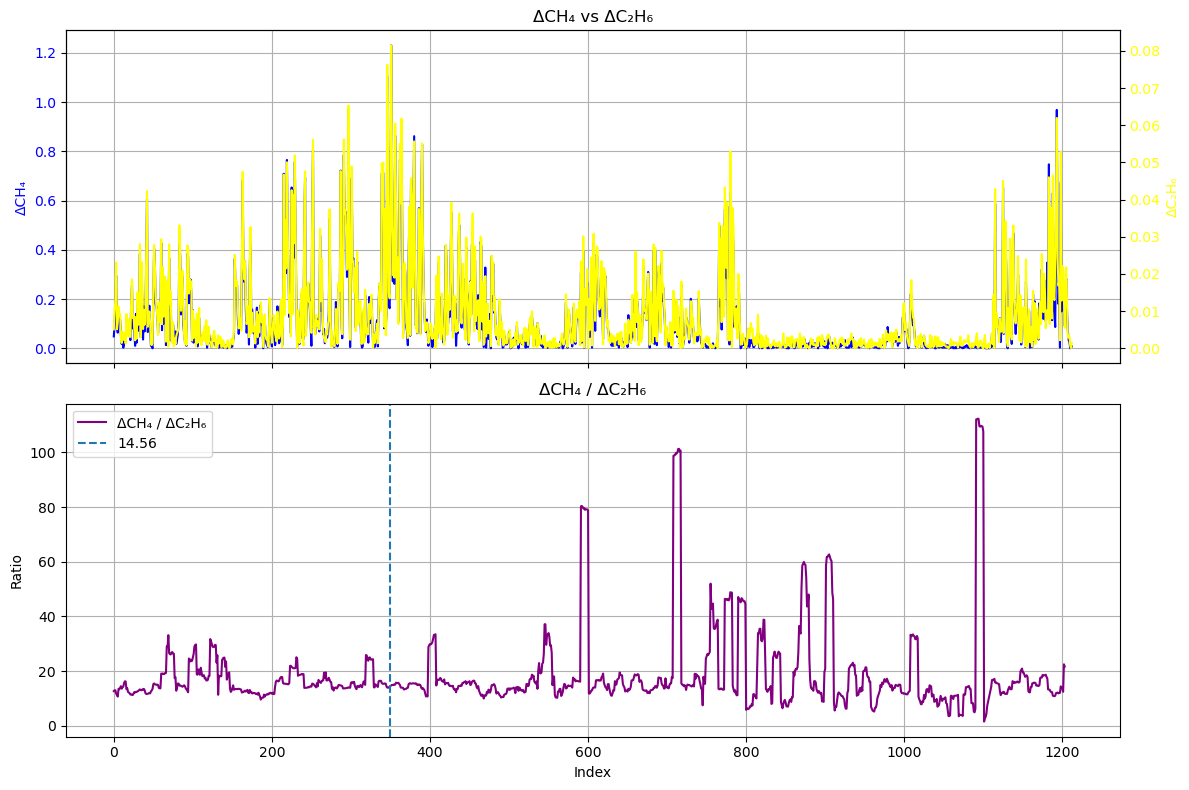

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(d_CH4, label='ΔCH₄', color='blue')
ax1.set_ylabel('ΔCH₄', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)
ax1.set_title('ΔCH₄ vs ΔC₂H₆')

ax1b = ax1.twinx()
ax1b.plot(d_C2H6, label='ΔC₂H₆', color='yellow')
ax1b.set_ylabel('ΔC₂H₆', color='yellow')
ax1b.tick_params(axis='y', labelcolor='yellow')

ax2.plot(ma_ratio, label='ΔCH₄ / ΔC₂H₆', color='purple')
ax2.set_ylabel('Ratio')
ax2.set_xlabel('Index')
ax2.axvline(350, linestyle='--', linewidth=1.5, label=f'{ma_ratio[350]:.2f}')
ax2.legend()
ax2.grid(True)
ax2.set_title('ΔCH₄ / ΔC₂H₆')

plt.tight_layout()
plt.show()

It can be seen that the parts of the differential sequence ratio that fluctuate dramatically, such as index 800-1000, correspond to parts with very low values in both the differential sequence and the original sequence. This means that this part of the signal actually comes from disturbances in the baseline and surrounding air, rather than from the plume of the natural gas station.

Here, we use the ratio at index 350, 14.56 as the ratio. However, please note that this value is affected by both the window length and the selection position.

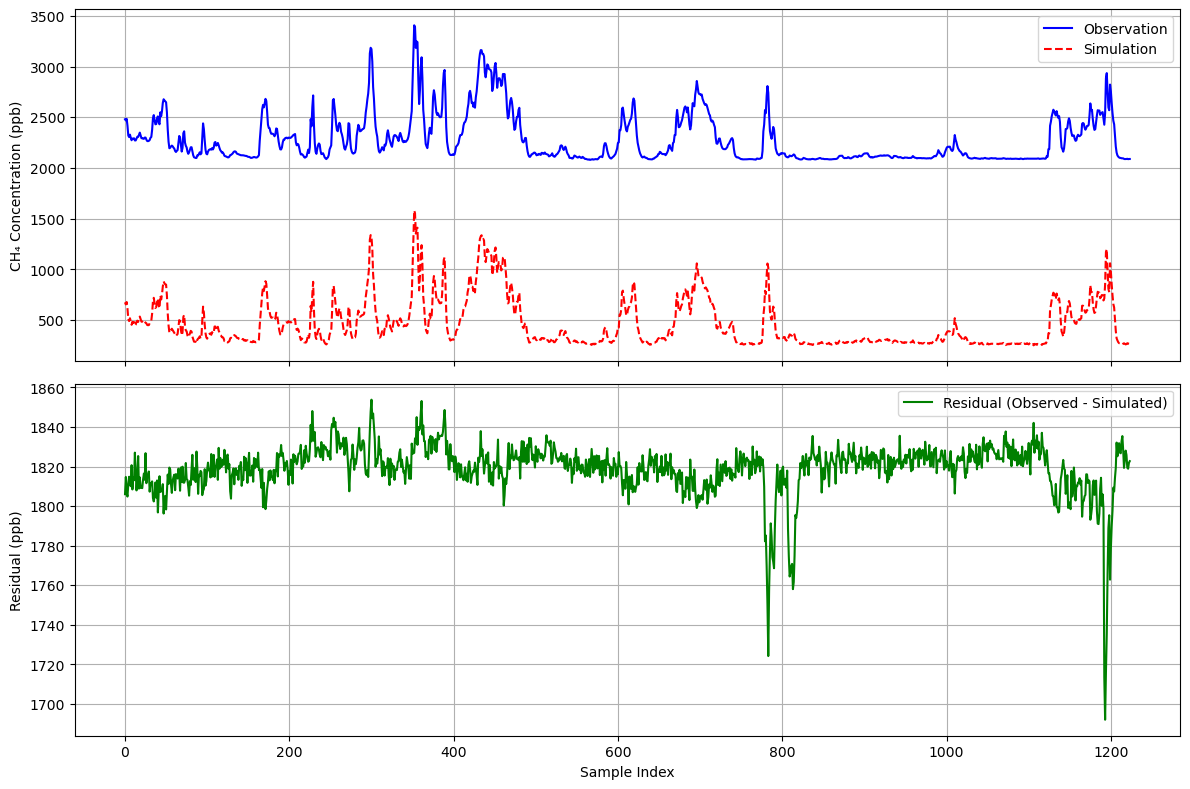

In [18]:
q_CH4_series = np.array(q_C2H6_series) * ma_ratio[350]

sim_CH4 = []
for q in q_CH4_series:
    c = gaussian_plume(
        np.array([sample_x]),
        np.array([sample_y]),
        [source_x],
        [source_y],
        [q],
        u, Ry, ry, Rz, rz, wind_deg,
        T, P, M, R
    )
    sim_CH4.append(c[0])

sim_CH4 = np.array(sim_CH4)

residual = CH4 - sim_CH4

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(CH4, label='Observation', color='blue')
ax1.plot(sim_CH4, label='Simulation', color='red', linestyle='--')
ax1.set_ylabel('CH₄ Concentration (ppb)')
#ax1.set_title('Observed vs Simulated CH₄')
ax1.legend()
ax1.grid(True)

ax2.plot(residual, label='Residual (Observed - Simulated)', color='green')
ax2.set_ylabel('Residual (ppb)')
ax2.set_xlabel('Sample Index')
#ax2.set_title('Residual between Observed and Simulated CH₄')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

It can be seen that the simulation accurately reproduces the changes in the methane curve and obtains a baseline of approximately 1820. This strategy is more effective when dealing with sources of different natures. It is easy to imagine that if there is another source of a different nature nearby, it will produce a peak similar to Example 1 in the residual plot.

## Summary
This notebook describes our general workflow for processing vehicle-based observation data, specifically:

* Used `matplotlib` and `folium` to plot and explore vehicle-based observation data.
* Used `numpy` to establish a Gaussian plume model for simulation experiments.
* Used `scipy` to test the relationship between signals.
* Run simulation experiments to verify whether the signal comes from a possible source, or to separate the regional baseline from the signal.

## Citing this Notebook

Please see [CITATION.cff](https://github.com/eds-book/dea59792-5a6d-4633-a74c-eb73edce61b8/blob/main/CITATION.cff) for the full citation information. The citation file can be exported to APA or BibTex formats (learn more [here](https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/about-citation-files)).

## Additional information
**Dataset**: The data used in this notebook comes from our measurements, which are part of a more extensive dataset that we are preparing for a data article.

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [19]:
from datetime import date

print('Notebook repository version: v2025.09.4')
print(f'Last tested: {date.today()}')

Notebook repository version: v2025.09.4
Last tested: 2025-12-03
